In [2]:
using CairoMakie, BenchmarkTools
using InterferometerSimulations

┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1342


In [3]:
using Pkg;
Pkg.add("PyCall"); Pkg.build("PyCall");

    Updating registry at `C:\Users\m163524\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\m163524\Dev\InterferometerSimulations\notebooks\Project.toml`
  No Changes to `C:\Users\m163524\Dev\InterferometerSimulations\notebooks\Manifest.toml`
    Building Conda ─→ `C:\Users\m163524\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\299304989a5e6473d985212c28928899c74e9421\build.log`
    Building PyCall → `C:\Users\m163524\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\169bb8ea6b1b143c5cf57df6d34d022a7b60c6db\build.log`


In [4]:
using PyCall

### Why Julia?

For demonstration we'll compare some functionality of this package originally written in python from [simulated_phasestep_correction collab notebook](https://colab.research.google.com/drive/1OBqKfVBW1IEr5nA9rJKcIorjilwPPgN4#scrollTo=zmBpLKb0jRoI)


In [5]:
py"""
import numpy as np
def ellipsoid(foci=(0.5, 0.5, 0.5), axes=(0.25, 0.25, 0.25), N=100):
  foci = np.round(np.array(foci)*N)
  axes = np.round(np.array(axes)*N)
  assert all([c - r > 0 for c, r in zip(foci, axes)])
  assert all([c + r < N for c, r in zip(foci, axes)])
  A = np.zeros((N, N, N))

  for i in range(N):
    for j in range(N):
      for k in range(N):
        if np.sqrt(((i-foci[0])/axes[0])**2 + ((j-foci[1])/axes[1])**2 + ((k-foci[2])/axes[2])**2) < 1:
          A[i, j, k] = 1
  return A

"""

In [6]:
@btime py"ellipsoid()";

  3.561 s (32 allocations: 7.63 MiB)


In [7]:
@btime ellipsoid();

  5.439 ms (4 allocations: 7.63 MiB)


That's why we are using Julia

# Simulating Grating Interferometry

This notebook walks through some of the basic functionality of this package `InterferometerSimulations.jl` which provides functionality to simulation grating interferometer phase stepping datasets. Such functionality is useful in validating correction algorithms by being able to generate ground truth digital phantoms to compare phase retrieval or reconstruction algorithms as well as simulate artifacts seen on real systems such as phase step jitter.

In [8]:
A = ellipsoid(N=256);

In [9]:
project(A,dims=1) = sum(A, dims=dims)[1,:,:] 

project (generic function with 2 methods)

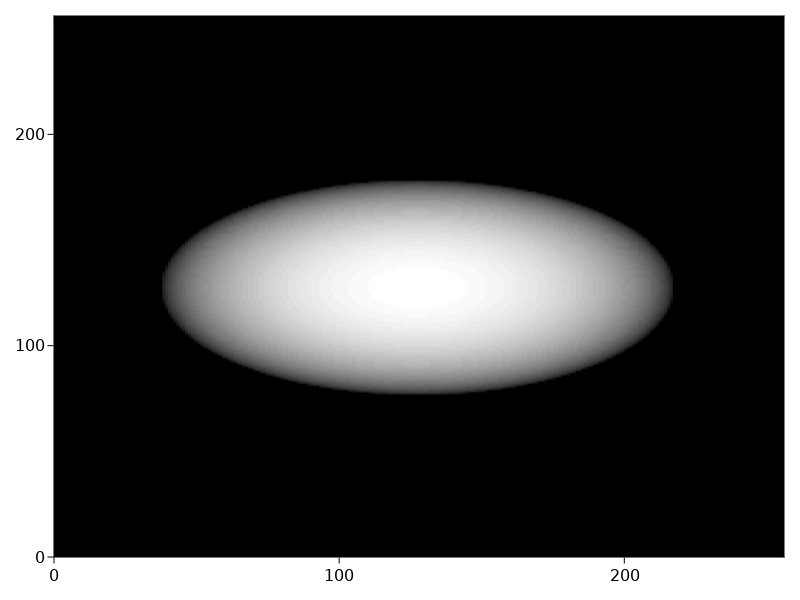

In [10]:
A = ellipsoid(foci=(0.5, 0.5, 0.5), axes=(0.2, 0.35, 0.2), N=256);
proj=project(A);
image(proj)

In [11]:
proj = phantom_dataset(A);

In [12]:
M, N = size(proj)

(256, 256)

In [13]:
fieldnames(typeof(proj))

(:atten, :phase, :vis)

![d](../interferometer_diagram.png)

## Introduce Moire Patterns and Phase Stepping

In grating interferometry the phase grating G1 produces an interference pattern of period equal to G1 (2.4 um in our system). Accounting for magnification at the face of the detector this period has almost doubled to 4.8 um. Since this period is inconviently small to measure with most detector pixel sizes, G2 is introduced to match the period of the interference pattern at the face of the detector. The local interference pattern is then sampled via a phase stepping procedure:

$$
I(x_n) = I_0 + A\sin{(2\pi\frac{x_n}{p_2} - \phi)}
$$

This is shown below for a single pixel


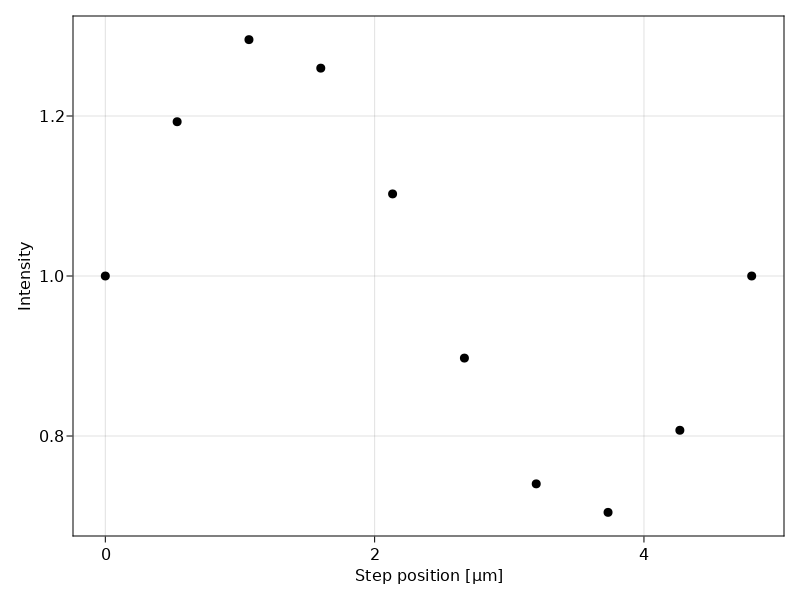

In [14]:
I0 = 1
A = 0.3
p2=4.8
x=LinRange(0, p2, 10)

f = Figure()
ax = Axis(f[1,1])
plot!(x, I0 .+ A*sin.(2π/p2*x))
ax.xlabel = "Step position [μm]"
ax.ylabel = "Intensity"
f

### Real Phase Stepping

Ideally the intensities in the plot above would be constant over the whole detector for each phase step such that whole detector uniformly increases then decreases in intensity according to the phase stepping equation above. However, in practice G2 never perfectly matches the period of the interference pattern due to conebeam effects and inaccurate alignment. When two repeating patterns partially overlap, an optical beat pattern is produced called a [Moiré pattern](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern). A Moire pattern magnifies the underlying interference pattern and can still be used to retrieve the underlying interference pattern properties. However the presence of Moire patterns means that a reference (i.e. flat-field) phase stepping curve must be acquired to remove the Moire pattern from the image, if the two curves do not perfectly annihilate then residual image artifacts remain.

In [15]:
@btime lateral_position = [i/M for i = range(1, M, step=1), j = range(1, N, step=1)]';

  1.736 ms (65547 allocations: 1.50 MiB)


In [16]:
lateral_position = [i/M for i = range(1, M, step=1), j = range(1, N, step=1)]';

In [17]:
using InterferometerSimulations.PhaseStepping: sample_moire_pattern

In [18]:
@btime sample_moire_pattern(proj);

  794.900 μs (27 allocations: 1.00 MiB)


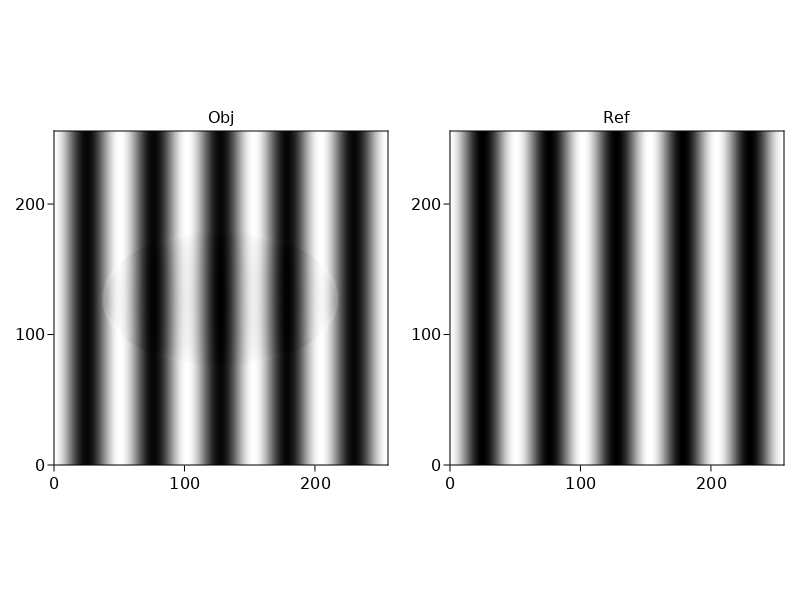

In [19]:
f = Figure()
ax1 = Axis(f[1, 1], title="Obj")
ax1.aspect = DataAspect()
image!(sample_moire_pattern(proj))
ax2 = Axis(f[1, 2],  title="Ref")
image!(sample_moire_pattern(proj, ref=true))
ax2.aspect = DataAspect()
f

In [20]:
nsteps = 10
nperiods = 1
ref = phase_step(proj, ref=true, nsteps=nsteps, nperiods=nperiods)
obj = phase_step(proj, nsteps=10)
size(ref), size(obj)

((256, 256, 10), (256, 256, 10))

In [25]:
using GratingInterferometry

In [26]:
stepdata = StepData(obj, ref, nperiods)

StepData
obj of size: (256, 256, 10)
ref of size: (256, 256, 10)
nperiods: 1


In [27]:
normalize(img) = clamp.(img ./ maximum(img), 0, 1)

normalize (generic function with 1 method)

In [28]:

 giffy(fname, stepdata::StepData) = save(fname, hcat([RGB.(normalize(stepdata.obj.I)) RGB.(normalize(stepdata.ref.I ))]))

giffy (generic function with 1 method)

In [ ]:
giffy("simsteps.gif", stepdata)

![](simsteps.gif)

In [31]:
proj = retrieve(stepdata)

In [30]:
f = Figure()
ax1 = Axis(f[1, 1])
image!(proj.atten[:,:,1])
ax1.aspect = DataAspect()
ax2 = Axis(f[1, 2])
image!(proj.dphase[:,:,1])
ax2.aspect = DataAspect()
ax3 = Axis(f[1, 3])
image!(proj.vis[:,:,1])
ax3.aspect = DataAspect()
f

LoadError: type PhaseContrastData has no field dphase

## Add System Phase Gradients

In [ ]:
true_proj = phantom_dataset()
nsteps = 16
nperiods=2
stepsize = nperiods/nsteps
steps = 2π*(0:stepsize:nperiods-stepsize)
## introduce Non homogenous reference phases of the system like in Hauke et al. 2017: <https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-25-26-32897&id=379595>
phasegrad = 3 * radial_gradient() + 2*vertical_gradient() ./ 4

ref = phase_step(true_proj, steps, ref=true, moireperiods=10, ϕ=phasegrad)
obj = phase_step(true_proj, steps, ref=false, moireperiods=10, ϕ=phasegrad)

##
ϕr = angle.(fft(ref, 3)[:,:,nperiods+1])
ϕo = angle.(fft(obj, 3)[:,:,nperiods+1])

dphase = unwrap(ϕo .- ϕr)